In [862]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
from data.utils import load_data


In [908]:
models = ['HadamardGP', 'SimpleGP', 'BRR', 'LSTM', 'XGBoost']
df_dict = {}
for model in models:
    print(model)
    df_dict[model] = load_data('Dissertation/reports/exogenous_6hr', f'{model}.csv')
    df_dict[model].drop(columns=['Unnamed: 0'], inplace=True)



HadamardGP
==> Loading data
==> Loaded data in: 0 m : 0 sec

SimpleGP
==> Loading data
==> Loaded data in: 0 m : 0 sec

BRR
==> Loading data
==> Loaded data in: 0 m : 0 sec

LSTM
==> Loading data
==> Loaded data in: 0 m : 0 sec

XGBoost
==> Loading data
==> Loaded data in: 0 m : 0 sec



In [920]:
nlpd_dict = {}
models = ['HadamardGP', 'SimpleGP', 'BRR']
for model in models:
    nlpd_dict[model] = load_data('Dissertation/reports/exogenous_2hr', f'{model}_nlpd.csv')
    nlpd_dict[model].drop(columns=['Unnamed: 0'], inplace=True)



==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [910]:
def plot_forecast_mae(ax, results : dict, season : Optional[str] = None, pred_points=24):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
    

    plt.rcParams.update({'font.family': 'Arial'})
    
    for i, key in enumerate(results.keys()):
        mean = results[key]['mean']
        ax.plot(np.arange(0, pred_points), mean, color=colors[i], linestyle=linestyles[i], label=key)
    title = season.upper()[0] + season[1:]
    ax.set_title(title, fontsize=20)
  

In [911]:
def boxplot_models(ax, results : dict):
    # boxplot of models MAE (mean and median)
    
    ax.boxplot([results[key]['mean'] for key in results.keys()], labels=results.keys(), showmeans=True)
    


In [912]:
def print_mae_table(dct, models, season : Optional[str] = None):
    """ 
    Print table with MAE
    """
    if season:
        print('-'*35)
        print(f'{" "*10} {season.upper()} {" "*10}')
    print('-'*35)
    print('| Model \t| MAE \t | STD Dev ')
    print('-'*35)
    for model in models:
        mae = dct[model].mean(axis=1).mean()
        std = dct[model].std(axis=1).mean()
        if model in ['BRR', 'LSTM']:
            print(f'| {model} \t\t | {mae:.3f} | {std:.3f} ')
        else:
            print(f'| {model} \t | {mae:.3f} | {std:.3f} ')
        

In [913]:
def print_nlpd_table(nlpd_dict, season : Optional[str] = None):
    dct = nlpd_dict.copy()
    if season:
        print('-'*35)
        print(f'{" "*10} {season.upper()} {" "*10}')
    print('-'*35)
    print('| Model \t| NLPD   | STD Dev ')
    print('-'*35)

    for model in dct.keys():
        # we have 1/N * p(y_i | theta_i)), so we sum column-wise to get 
        # 1 / N \sum_{n=1}^N p(y_i \theta_i) 
        dct[model] = dct[model].sum()
        mae = dct[model].median()
        std = dct[model].std()
        if model == 'BRR':
            print(f'| {model} \t\t | {mae:.3f} | {std:.6f} ')
        else:
            print(f'| {model} \t | {mae:.3f} | {std:.6f} ')

In [914]:
print_nlpd_table(nlpd_dict)

-----------------------------------
| Model 	| NLPD   | STD Dev 
-----------------------------------
| HadamardGP 	 | -0.903 | 0.868637 
| SimpleGP 	 | -0.722 | 1.035155 
| BRR 		 | -0.325 | 0.545716 


In [915]:
print_mae_table(df_dict, models)

-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| HadamardGP 	 | 0.099 | 0.100 
| SimpleGP 	 | 0.111 | 0.113 
| BRR 		 | 0.102 | 0.099 


In [916]:
# we have 52 weeks and 6 systems --> 52*6 = 312 "weeks" in total starting from 1. Jan 2018

def winter_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx < 9*n_systems or idx > 48*n_systems]

def spring_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 9*n_systems and idx <= 22*n_systems]

def summer_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 22*n_systems and idx <= 35*n_systems]

def autumn_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 35*n_systems and idx <= 48*n_systems]

def filter_season(df_dict, models, season, split_str: str = 'mae', forecast_horizon : Optional[int] = None):
    
    filtered = {}
    experiment_idx = [int((col.split(split_str)[-1])) if len(col.split(split_str)) > 1 else -1 for col in df_dict[models[0]].columns]
    
    if season == 'winter':
        idx = winter_idx(experiment_idx)
    elif season == 'spring':
        idx = spring_idx(experiment_idx)
    
    elif season == 'summer':
        idx = summer_idx(experiment_idx)
    
    elif season == 'autumn':
        idx = autumn_idx(experiment_idx)
    else:
        raise ValueError('Season must be one of: winter, spring, summer, autumn')
    
    for model in models:
        try:
            if forecast_horizon:
                filtered[model] = df_dict[model].iloc[:forecast_horizon, idx]
            else:
                filtered[model] = df_dict[model].iloc[:, idx]
        except IndexError:
            idx = [i for i in idx if i < df_dict[model].shape[1]]
            if forecast_horizon:
                filtered[model] = df_dict[model].iloc[:forecast_horizon, idx]
            else:
                filtered[model] = df_dict[model].iloc[:, idx]
    
    for model in models:
        if 'Unnamed: 0' in filtered[model].columns:
            # ignore SettingWithCopyWarning
            with pd.option_context('mode.chained_assignment', None):
                filtered[model].drop('Unnamed: 0', axis=1, inplace=True)

    return filtered

72
-----------------------------------
           SPRING           
-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| HadamardGP 	 | 0.119 | 0.109 
| SimpleGP 	 | 0.152 | 0.134 
| BRR 		 | 0.126 | 0.114 
| LSTM 		 | 0.158 | 0.143 
| XGBoost 	 | 0.124 | 0.122 
-----------------------------------
           SPRING           
-----------------------------------
| Model 	| NLPD   | STD Dev 
-----------------------------------
| HadamardGP 	 | -0.606 | 0.709812 
| SimpleGP 	 | -0.477 | 1.101992 
| BRR 		 | -0.185 | 0.612161 
-----------------------------------
           SUMMER           
-----------------------------------
| Model 	| MAE 	 | STD Dev 
-----------------------------------
| HadamardGP 	 | 0.119 | 0.108 
| SimpleGP 	 | 0.132 | 0.115 
| BRR 		 | 0.129 | 0.107 
| LSTM 		 | 0.147 | 0.133 
| XGBoost 	 | 0.150 | 0.138 
-----------------------------------
           SUMMER           
-----------------------------------
| Model 	| N

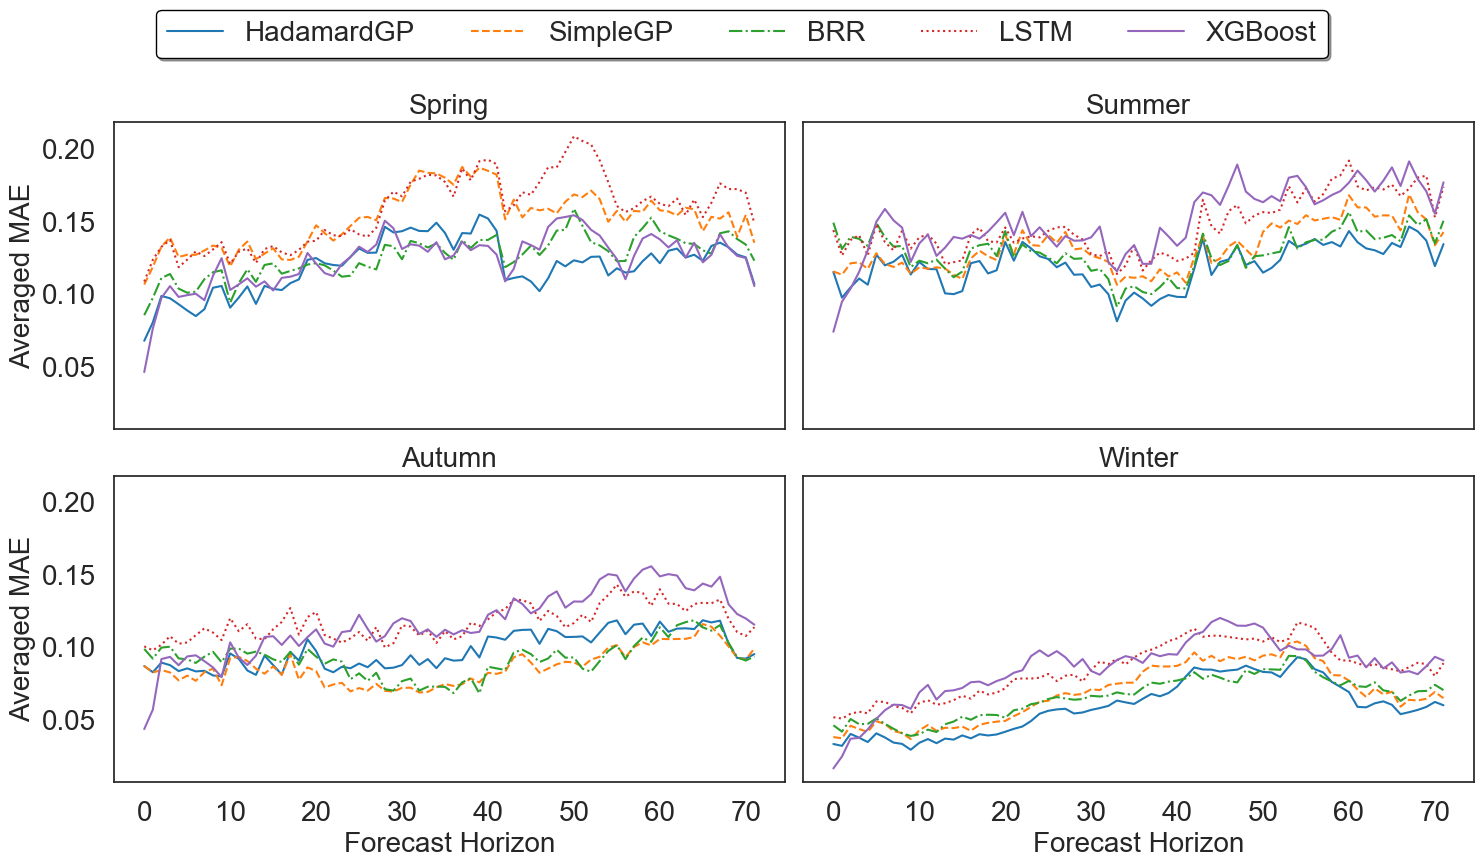

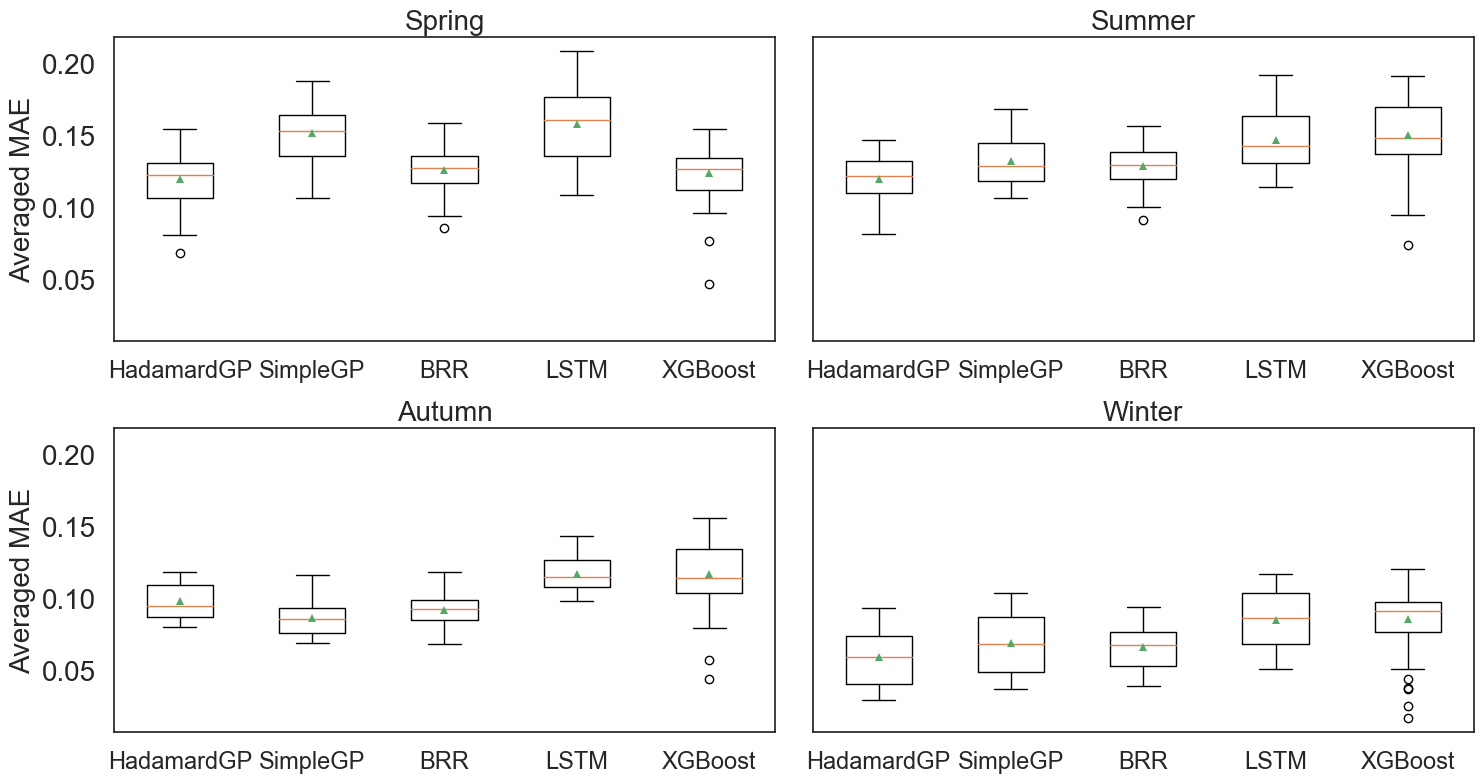

In [918]:
from metrics import get_mean_ci
plt.rcParams.update({'font.family': 'Arial'})
fig, ax = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True)
fig2, ax2 = plt.subplots(2, 2, figsize=(15, 8), sharex=False, sharey=True)

ax = ax.flatten()
ax2 = ax2.flatten()
# change horizon to 24 for 2hr and 72 for 6hr
horizon = len(df_dict['HadamardGP'].iloc[:, 0])
print(horizon)
hour = horizon // 12
models = ['HadamardGP', 'SimpleGP','BRR', 'LSTM', 'XGBoost']
models_nlpd = ['HadamardGP', 'SimpleGP', 'BRR',]

for i, season in enumerate(['spring', 'summer', 'autumn', 'winter']):
    # change split string of dict_season to 'mae' for 6hr and '_' for 2hr
    dict_season = filter_season(df_dict, models, season, forecast_horizon=horizon, split_str='mae')
    nlpd_season = filter_season(nlpd_dict, models_nlpd, season, split_str='_', forecast_horizon=horizon)
    results = {}
    print_mae_table(dict_season, models, season)
    print_nlpd_table(nlpd_season, season)
    for model in dict_season.keys():
        mean, lower, upper = get_mean_ci(dict_season[model])
        results[model] = {'mean': mean, 'lower': lower, 'upper': upper}

    plot_forecast_mae(ax[i], results, pred_points=mean.shape[0], season=season)
    boxplot_models(ax2[i], results)

    title = season.upper()[0] + season[1:]
    ax2[i].set_title(title, fontsize=20)
    
    if i == 0:
        # get legends and set at the top middle of the entire figure instead of each subplot
        # set it in a shaded box with edgecolor='black'
        handles, labels = ax[i].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=20,
                     bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, edgecolor='black',
                     frameon=True, framealpha=1.0)
    
    # set ylabel only for left plots
    if i % 2 == 0:
        ax[i].set_ylabel('Averaged MAE', fontsize=20)
        ax2[i].set_ylabel('Averaged MAE', fontsize=20)
        # set size of yticks
        ax[i].yaxis.set_tick_params(labelsize=20)
        ax2[i].yaxis.set_tick_params(labelsize=20)

        
    
    # set xlabel only for bottom plots
    if i >= 2:
        #ax[i].set_xticks(np.arange(0, len(mean), 5), np.arange(0, len(mean) + 1, 5), fontsize=15)
        ax[i].set_xticks(np.arange(0, len(mean), 10), np.arange(0, len(mean) + 1, 10), fontsize=20)

        ax[i].set_xlabel('Forecast Horizon', fontsize=20)



# set xticks for to be the models for the boxplots
for i in range(4):
    ax2[i].set_xticks(np.arange(1, len(models)+1), models, fontsize=17)

fig.tight_layout()
fig2.tight_layout()
fig.savefig(f'lineplot_models{hour}hr_exg.png', dpi=300, bbox_inches='tight')
fig2.savefig(f'boxplot_models{hour}hr_exg.png', dpi=300, bbox_inches='tight')



In [892]:
from typing import Optional
import seaborn as sns

def boxplot_forecast_horizon(df_dict, season : Optional[str] = None):
    
    fig, ax = plt.subplots(len(df_dict) // 2, 3, figsize=(20, 6), sharey=True, sharex=False)
    plt.rcParams.update({'font.family': 'Arial'})
    ax = ax.flatten()
    pred_points = df_dict[list(df_dict.keys())[0]].shape[0]
    print(pred_points)
    for i,  (key, df) in enumerate(df_dict.items()):
        df_transposed = df.T
        sns.boxplot(data=df_transposed, ax=ax[i], 
                    showfliers=False,
                    medianprops={'color':'b', },
                    showmeans=True, color='white', 
                    meanprops={'marker':'^','markerfacecolor':'red'},)
        
        ax[i].set_title(key, fontsize=25)
        if i % 3 == 0:
            ax[i].set_ylabel('MAE Errors', fontsize=25)
            ax[i].yaxis.set_tick_params(labelsize=25)
        if pred_points <= 24:
            ax[i].set_xticks(np.arange(0, pred_points, 5), np.arange(0, pred_points + 1, 5), fontsize=20)
            ax[i].xaxis.set_tick_params(labelsize=25)
        else:
            ax[i].set_xticks(np.arange(0, pred_points, 10), np.arange(0, pred_points + 1, 10), fontsize=20)
            ax[i].xaxis.set_tick_params(labelsize=25)


        ax[i].set_xlabel('Forecast Steps', fontsize=25)
      

    # remove unused plots
    if len(df_dict) % 3 != 0:
        ax[-1].remove()
        
    hour = pred_points // 12
    plt.tight_layout()
    plt.savefig(f'forecast_{hour}hr_exg.png', dpi=300, bbox_inches='tight')
    plt.show();

In [893]:
best_model_dict = {model : df_dict[model] for model in ['HadamardGP','SimpleGP', 'BRR']}

24


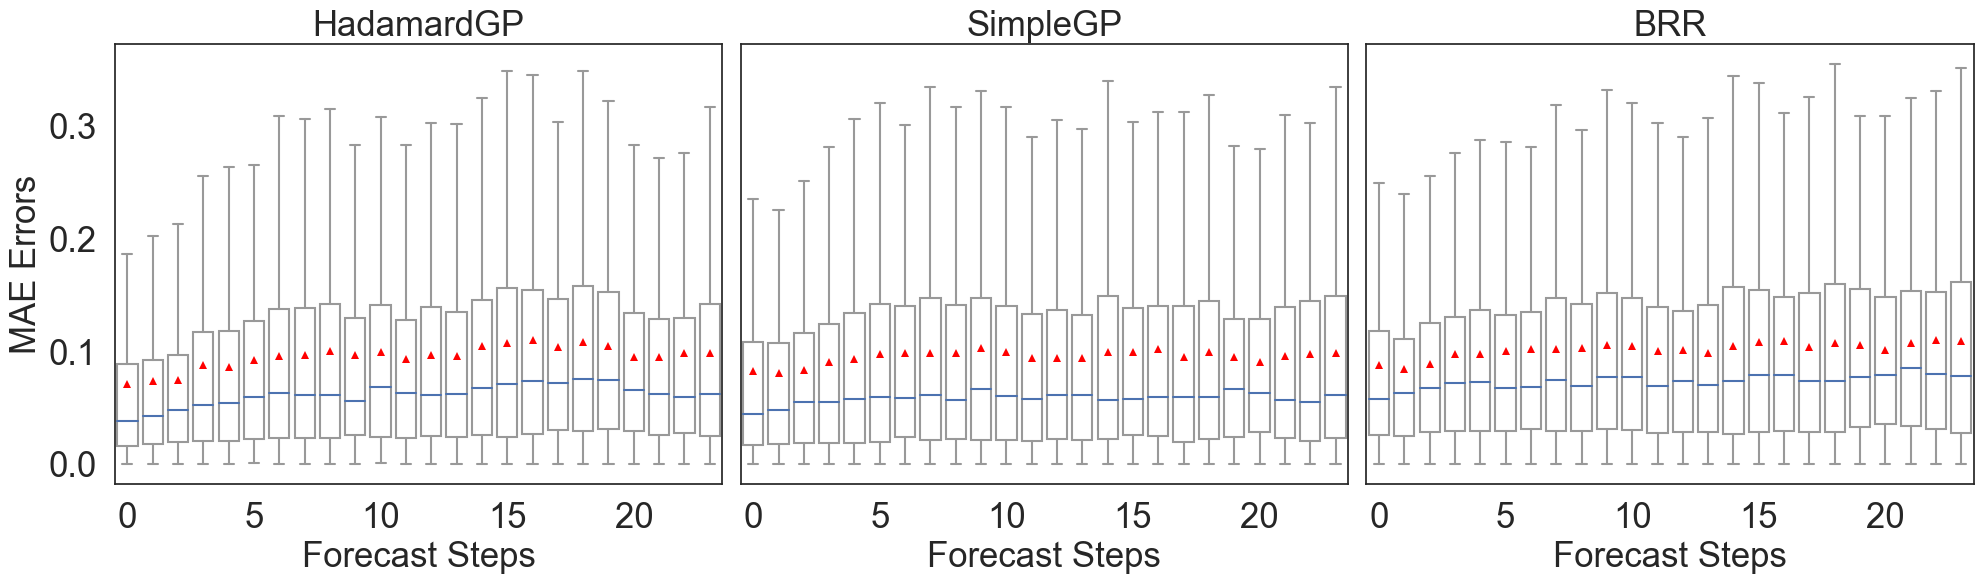

In [894]:
boxplot_forecast_horizon(best_model_dict)

In [899]:
nlpd_dict['HadamardGP'].describe()

,NLPD_0,NLPD_1,NLPD_2,NLPD_3,NLPD_4,NLPD_5,NLPD_6,NLPD_7,NLPD_8,NLPD_9,NLPD_10,NLPD_11,NLPD_12,NLPD_13,NLPD_14,NLPD_15,NLPD_16,NLPD_17,NLPD_18,NLPD_19,NLPD_20,NLPD_21,NLPD_22,NLPD_23,NLPD_24,NLPD_25,NLPD_26,NLPD_27,NLPD_28,NLPD_29,NLPD_30,NLPD_31,NLPD_32,NLPD_33,NLPD_34,NLPD_35,NLPD_36,NLPD_37,NLPD_38,NLPD_39,...,NLPD_272,NLPD_273,NLPD_274,NLPD_275,NLPD_276,NLPD_277,NLPD_278,NLPD_279,NLPD_280,NLPD_281,NLPD_282,NLPD_283,NLPD_284,NLPD_285,NLPD_286,NLPD_287,NLPD_288,NLPD_289,NLPD_290,NLPD_291,NLPD_292,NLPD_293,NLPD_294,NLPD_295,NLPD_296,NLPD_297,NLPD_298,NLPD_299,NLPD_300,NLPD_301,NLPD_302,NLPD_303,NLPD_304,NLPD_305,NLPD_306,NLPD_307,NLPD_308,NLPD_309,NLPD_310,NLPD_311
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.004692,-0.105948,0.070226,-0.067977,-0.011816,0.058152,-0.089668,-0.088356,-0.125824,-0.116362,-0.080002,-0.009734,-0.189674,-0.159376,-0.190292,-0.163883,-0.188354,-0.198709,-0.022105,-0.079417,-0.026293,-0.077725,-0.060055,-0.033244,0.009718,-0.080333,-0.044255,-0.079254,-0.037814,0.004955,-0.055419,-0.042577,-0.060739,-0.034215,-0.065867,-0.065487,-0.047211,-0.006259,-0.000573,-0.005473,...,-0.018019,-0.033556,0.046393,0.001742,-0.054393,-0.061644,-0.051524,-0.042976,-0.038308,-0.056390,-0.172414,-0.154146,-0.158185,-0.141633,-0.179824,-0.170724,-0.075088,-0.068006,-0.069576,-0.070146,-0.061243,-0.068867,-0.073800,-0.063117,-0.065338,-0.051061,-0.056777,-0.053017,-0.351749,-0.409065,-0.386547,-0.355044,-0.357316,-0.444138,-0.083389,-0.073056,-0.084398,-0.077508,-0.080706,-0.087323
std,0.066028,0.049826,0.067178,0.039529,0.059453,0.068215,0.008685,0.014748,0.079095,0.017088,0.014608,0.015586,0.139638,0.144925,0.150281,0.139454,0.149169,0.142734,0.091871,0.017286,0.081266,0.014903,0.031712,0.065706,0.066257,0.031566,0.039761,0.030597,0.019505,0.034225,0.014644,0.019975,0.010013,0.036109,0.006774,0.012137,0.014125,0.041035,0.048849,0.080302,...,0.030054,0.028870,0.092321,0.070256,0.018461,0.013752,0.014303,0.012584,0.017273,0.014689,0.135958,0.106967,0.120216,0.103122,0.122079,0.151667,0.011000,0.014892,0.016383,0.010266,0.014801,0.009856,0.027220,0.015979,0.016357,0.028902,0.016750,0.026577,0.115274,0.275864,0.109924,0.111005,0.125127,0.226215,0.007502,0.016554,0.004419,0.008240,0.012545,0.009670
min,-0.125780,-0.315266,-0.094597,-0.174945,-0.116315,-0.099987,-0.105548,-0.112693,-0.412028,-0.157831,-0.102658,-0.056276,-0.426540,-0.433675,-0.482145,-0.431898,-0.432605,-0.433174,-0.091558,-0.108487,-0.095961,-0.107740,-0.100520,-0.089137,-0.109248,-0.135075,-0.112292,-0.135108,-0.104548,-0.093257,-0.067247,-0.066455,-0.076355,-0.065216,-0.081955,-0.086696,-0.068193,-0.047234,-0.067116,-0.058676,...,-0.052067,-0.074973,-0.049135,-0.056664,-0.093013,-0.089785,-0.075757,-0.063185,-0.074914,-0.079508,-0.494980,-0.388395,-0.413169,-0.447966,-0.400279,-0.586829,-0.093650,-0.101169,-0.095515,-0.095680,-0.085124,-0.085937,-0.113250,-0.090344,-0.101210,-0.089303,-0.085259,-0.091135,-0.463608,-1.029041,-0.554753,-0.433538,-0.529997,-1.152111,-0.091061,-0.086486,-0.091846,-0.089267,-0.098961,-0.102552
25%,-0.050078,-0.098738,0.048996,-0.085031,-0.065983,0.008631,-0.097441,-0.100555,-0.118859,-0.127250,-0.091104,-0.015910,-0.287972,-0.117624,-0.295149,-0.114929,-0.316718,-0.2

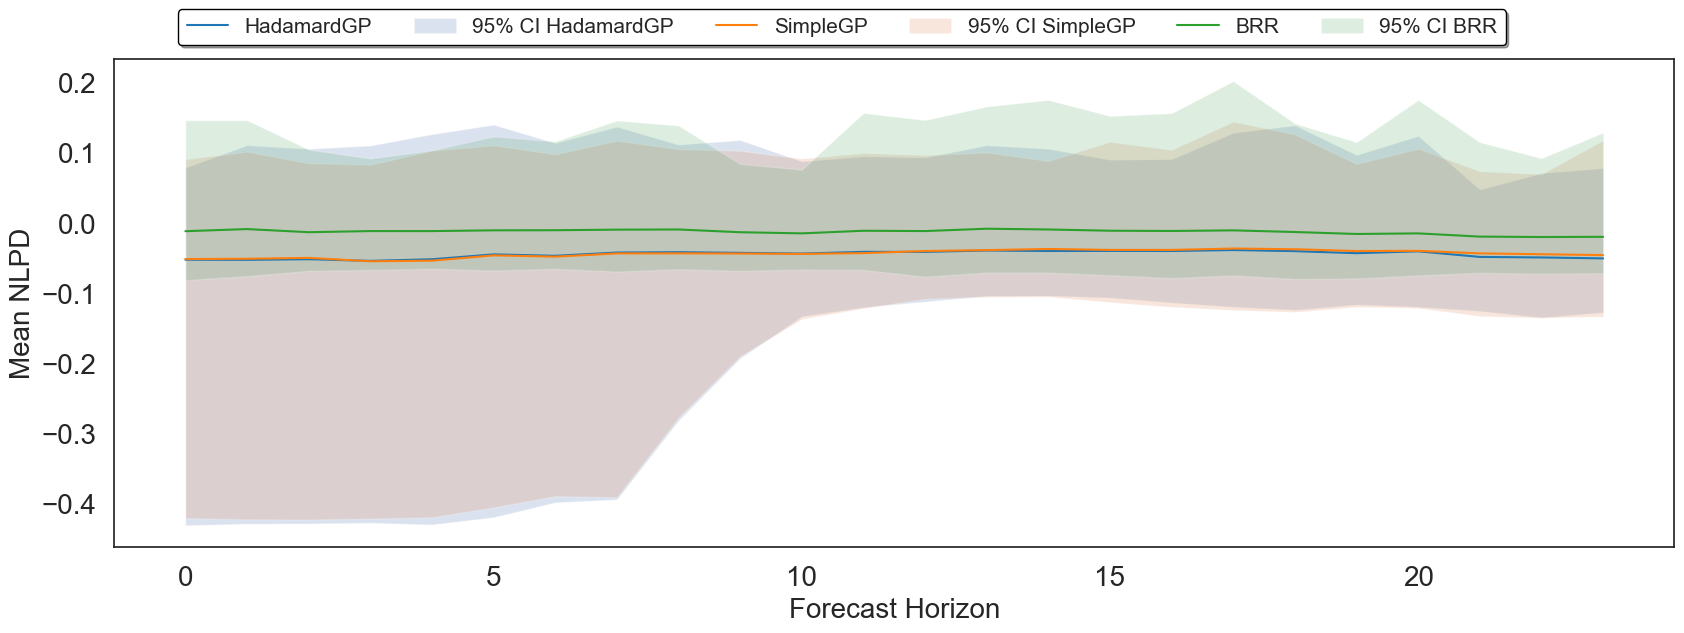

In [921]:
def plot_nlpd_horizon(nlpd_dict):
    
    fig, ax = plt.subplots(1, 1, figsize=(17, 6), sharey=True, sharex=False)
    color_list = sns.color_palette('tab10', len(nlpd_dict))
    plt.rcParams.update({'font.family': 'Arial'})

    x = np.arange(0, len(nlpd_dict['HadamardGP'].mean(axis=1)))

    for i, (key, df) in enumerate(nlpd_dict.items()):
        # get row-wise mean
        mean = df.mean(axis=1) 
        # get 95% confidence interval 
        lower, upper = df.quantile(0.025, axis=1), df.quantile(0.975, axis=1)

        ax.plot(x, mean[::-1], label=key, color=color_list[i])
        ax.fill_between(x, lower[::-1], upper[::-1], alpha=0.2, label=f'95% CI {key}')
       
    ax.xaxis.set_tick_params(labelsize=20)
    
    ax.set_ylabel('Mean NLPD', fontsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.set_xlabel('Forecast Horizon', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=8, fontsize=15,
                        bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, edgecolor='black',
                        frameon=True, framealpha=1.0)
        
        
       
    plt.tight_layout()
    plt.show();

plot_nlpd_horizon(nlpd_dict)

In [896]:
def winter_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx < 9*n_systems or idx > 48*n_systems]

def spring_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 9*n_systems and idx <= 22*n_systems]

def summer_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 22*n_systems and idx <= 35*n_systems]

def autumn_idx(experiment_idx, n_systems=6):
    return [idx for idx in experiment_idx if idx > 35*n_systems and idx <= 48*n_systems]

def get_season_idx(idx, season :str, n_systems=6):
    if season == 'winter':
        return winter_idx(idx, n_systems)
    elif season == 'spring':
        return spring_idx(idx, n_systems)
    elif season == 'summer':
        return summer_idx(idx, n_systems)
    elif season == 'autumn':
        return autumn_idx(idx, n_systems)
    else:
        raise ValueError('Season must be one of: winter, spring, summer, autumn')

In [897]:
models = ['HadamardGP', 'SimpleGP']
pct_dict_6hr = {}
pct_dict_2hr = {}
for model in models:
    pct_dict_6hr[model] = load_data('Dissertation/reports/exogenous_6hr', f'{model}_pct.csv')
    pct_dict_6hr[model].drop(columns=['Unnamed: 0'], inplace=True)

    pct_dict_2hr[model] = load_data('Dissertation/reports/exogenous_2hr', f'{model}_pct.csv')
    pct_dict_2hr[model].drop(columns=['Unnamed: 0'], inplace=True)



==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [877]:
pct_dict_2hr['SimpleGP'].columns = [f'pct{i}' for i in range(0, len(pct_dict_2hr['SimpleGP'].columns))]


In [878]:
def plot_percent_dict(dct_2hr, dct_6hr, models=['HadamardGP', 'SimpleGP']):
    fig, ax = plt.subplots(2, 4, figsize=(15, 6), sharex=True)

    # Create an array of axes for the second row
    ax_second_row = ax[1]

    ax = ax.flatten()
    plt.rcParams.update({'font.family': 'Arial'})

    for i, season in enumerate(['winter', 'spring', 'summer', 'autumn']):

        idx_2hr = [int((col.split('pct')[-1])) for col in dct_2hr[model].columns for model in models]
        idx_6hr = [int((col.split('pct')[-1])) for col in dct_6hr[model].columns for model in models]

        dict_season_2hr = {model: dct_2hr[model].iloc[:, get_season_idx(idx_2hr, season)] for model in models}
        dict_season_6hr = {model: dct_6hr[model].iloc[:, get_season_idx(idx_6hr, season)] for model in models}

        sns.histplot(dict_season_2hr['HadamardGP'].T, ax=ax[i], label='Hadamard GP', alpha=0.3, palette='tab10',
                     bins=12, legend='Hadamard GP')
        sns.histplot(dict_season_2hr['SimpleGP'].T, ax=ax[i], label='Simple GP', alpha=0.3, palette='husl',
                     bins=12, legend='Simple GP')

        # plot 6 hour on the second row
        sns.histplot(dict_season_6hr['HadamardGP'].T, ax=ax_second_row[i], label='Hadamard GP', alpha=0.3,
                     palette='tab10', bins=12, legend='Hadamard GP')
        sns.histplot(dict_season_6hr['SimpleGP'].T, ax=ax_second_row[i], label='Simple GP', alpha=0.3,
                     palette='husl', bins=12, legend='Simple GP')

        c_gp = sns.color_palette('husl')[0]
        ax[i].axvline(dict_season_2hr['HadamardGP'].median().median(), color='tab:blue', linestyle='-.',
                       label='Hadamard GP Median')
        ax[i].axvline(dict_season_2hr['SimpleGP'].median().median(), color=c_gp, linestyle='--',
                       label='Simple GP Median')
        ax_second_row[i].axvline(dict_season_6hr['HadamardGP'].median().median(), color='tab:blue',
                                 linestyle='-.', label='Hadamard GP Median')
        ax_second_row[i].axvline(dict_season_6hr['SimpleGP'].median().median(), color=c_gp, linestyle='--',
                                 label='Simple GP Median')
        title = season.upper()[0] + season[1:]
        ax[i].set_title(title, fontsize=20)
        ax_second_row[i].set_xlabel('PV Values Inside 95% CI', fontsize=15)
       
        if i == 0:
            # get legends and set at the top middle of the entire figure instead of each subplot
            # set it in a shaded box with edgecolor='black'
            handles, labels = ax[i].get_legend_handles_labels()
            fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=20,
                        bbox_to_anchor=(0.5, 1.1), fancybox=True, shadow=True, edgecolor='black',
                        frameon=True, framealpha=1.0)
            ax[i].set_ylabel('Count 2 Hours', fontsize=15)
            ax_second_row[i].set_ylabel('Count 6 Hours', fontsize=15)
            ax[i].yaxis.set_tick_params(labelsize=15)
            ax_second_row[i].yaxis.set_tick_params(labelsize=15)
            # remove legend
            ax[i].legend().remove()
            ax_second_row[i].legend().remove()
        else:
            # remove legend
            ax[i].legend().remove()
            ax_second_row[i].legend().remove()
            # remove yticks and yticklabels
            ax[i].set_yticks([])
            ax_second_row[i].set_yticks([])
            # remove ylabel
            ax[i].set_ylabel('')
            ax_second_row[i].set_ylabel('')

        ax_second_row[i].set_xticks(range(0, 101, 20))  # Set the tick locations as numerical values
        ax_second_row[i].set_xticklabels([f'{i}%' for i in range(0, 101, 20)], fontsize=15)  # Set the tick labels as formatted strings

        ax[i].yaxis.set_tick_params(labelsize=15)
        ax_second_row[i].yaxis.set_tick_params(labelsize=15)

    # Set y-axis limits for the second row (0 to 70)
    for i in range(0, 4):
        ax_second_row[i].set_ylim(0, 70)

    plt.tight_layout()
    plt.savefig(f'percent_inside_ci_exg.png', dpi=300, bbox_inches='tight')
    plt.show()


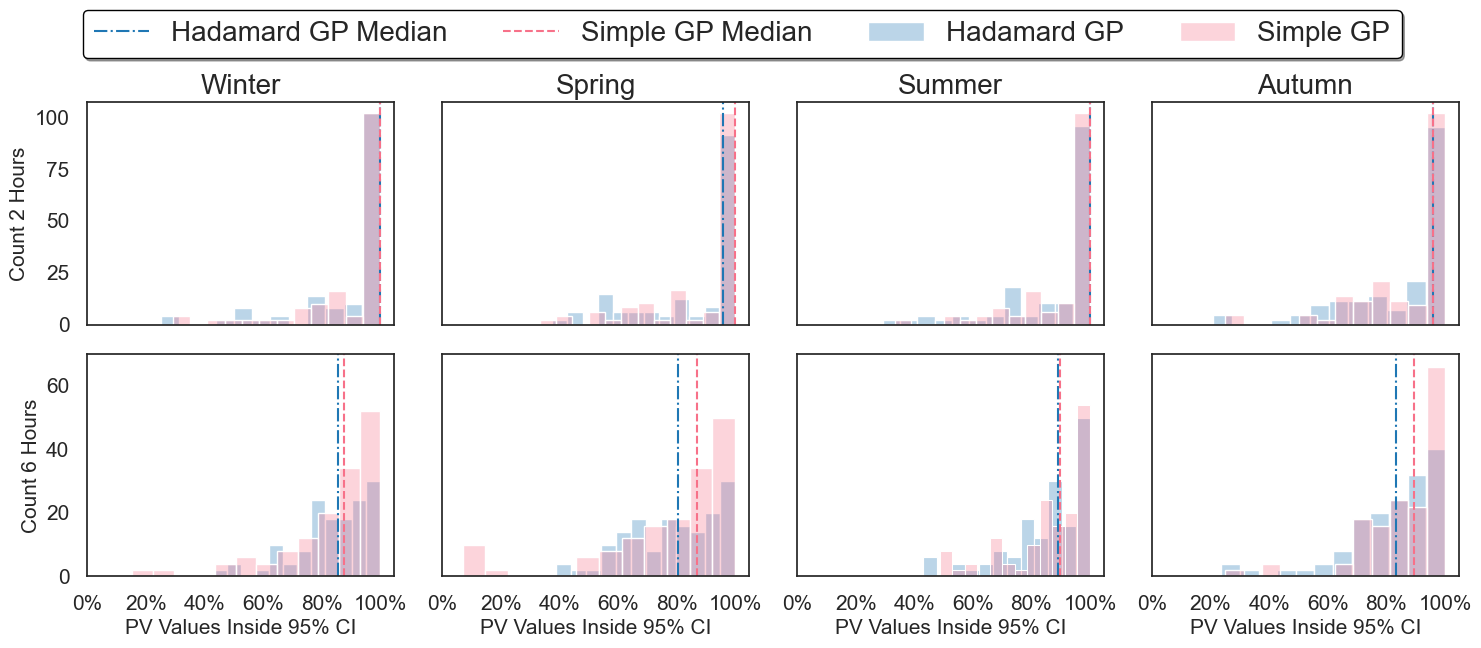

In [879]:
plot_percent_dict(pct_dict_2hr, pct_dict_6hr)
